# Assessment criteria

Is the code well commented and easy to follow?
Is it consistent (i.e. consistent names for
variables, functions, etc.)? does it use informative
names for variables and functions? Does it give
the results as stated in the paper?

# Todo:
Outliers for string columns and population
Imputation - for population and amount_tsh
Normalisation/standardisation
Fancy graphs

In [1]:
# Preamble/imports
import pandas as pd # for df manipulation
import numpy as np # for additional data analysis functionality
import missingno as msno # for missing number analysis
import seaborn as sns # for data visualisation
import matplotlib.pyplot as plt # for data visualisation
import datetime as dt # for manipulation of the date column
from sklearn import linear_model # For regression analysis
import copy # for deep copying the dataset class, so we can have both joint and separate analysis
from sklearn.decomposition import PCA # For Principal Component Analysis

# JB's imports for the geographical graph
import geopandas as gpd
import descartes
from shapely.geometry import Point, Polygon

In [2]:
training_dep_var = pd.read_csv('Training set labels.csv') # , index_col=0
training_indep_vars = pd.read_csv('Training set values.csv')
training_df = training_dep_var.merge(training_indep_vars, on='id')

In [3]:
test_df = pd.read_csv('Test set values.csv') # , index_col=0

/tmp/ipykernel_62906/2464380950.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  tf.write(training_df.loc[:, training_df.columns != 'id'].describe().round(1).to_latex(float_format="{:.1f}".format))


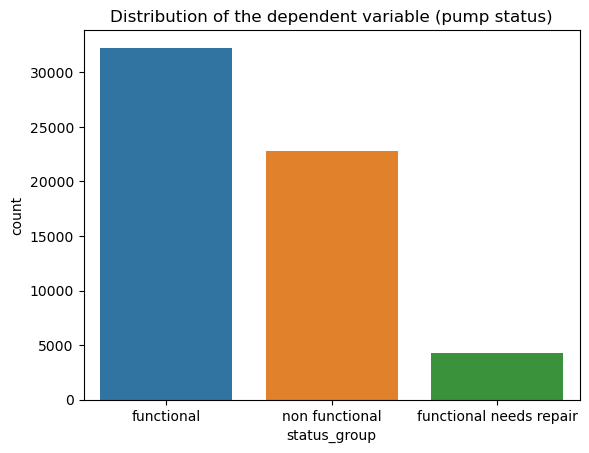

In [4]:
# Export summary stats to tex
with open('Output/summary_stats.tex','w') as tf:
    tf.write(training_df.loc[:, training_df.columns != 'id'].describe().round(1).to_latex(float_format="{:.1f}".format))

# Export dep_var bar graph
sns.countplot(data=training_df, x="status_group").set_title('Distribution of the dependent variable (pump status)')
plt.savefig('Output/dep_var.png', dpi=1200)

In [7]:
class Dataset:
    def __init__(self, data, training_data=None):
        self.df = data.copy()
        self.ids = self.df['id']
        self.nans_col = 'NaNs'
        self.dep_var = 'status_group'
        self.cat_cols = ['funder', 'installer', 'basin', 'region', 'permit', 'extraction_type_class', 'management_group', 'payment_type', 'water_quality', 'quantity', 'source']
        self.training_data = training_data

    def convert_datetime(self):
        # Initial cleaning
        self.df['date_recorded'] = pd.to_datetime(self.df['date_recorded']) # Convert dates to datetime

    def convert_missing_values(self, training_data=True): # Braganza and Pointon
        # Missing values
        self.df.loc[self.df['longitude']==0.0, 'longitude'] = np.nan # incorrect values
        self.df.loc[self.df['latitude']==-2.000000e-08, 'latitude'] = np.nan # incorrect values
        self.df.loc[self.df['gps_height']==0, 'gps_height'] = np.nan # very likely to be incorrect
        self.df.loc[self.df['construction_year']==0, 'construction_year'] = np.nan # incorrect values
        self.df.loc[(self.df['population']==0), 'population'] = np.nan # very likely to be incorrect # & (df['status_group']!='non functional')
        self.df.loc[(self.df['population']>50000), 'population'] = np.nan # very likely to be incorrect
        # self.df[self.df['installer'].str.contains("gov")].value_counts('installer')
        self.df.loc[self.df['installer']=='0', 'installer'] = np.nan # very likely to be incorrect
        self.df.loc[self.df['installer']=='-', 'installer'] = np.nan # functional change
        self.df.loc[self.df['funder']=='0', 'funder'] = 'unknown' # very likely to be incorrect
        self.df['gps_height'] = abs(self.df['gps_height']) # incorrect as per https://www.cia.gov/the-world-factbook/countries/tanzania/
        self.df.loc[self.df['amount_tsh']>400, 'amount_tsh'] = np.nan # very likely to be incorrect
        self.df.loc[self.df['date_recorded']<pd.Timestamp(2010, 1, 1), 'date_recorded'] = self.df.loc[self.df['date_recorded']<pd.Timestamp(2010, 1, 1), 'date_recorded'] + pd.offsets.DateOffset(years=10) # any dates before 2010 are wrong and probably 10 years out due to a typo...

        if training_data:
            self.df.loc[(self.df['amount_tsh']==0) & (self.df['status_group']=='functional'), 'amount_tsh'] = np.nan # very likely to be incorrect
            self.df.loc[(self.df['amount_tsh']==0) & (self.df['status_group']=='non functional'), 'amount_tsh'] = np.nan # very likely to be incorrect

    def convert_missing_to_unkown(self):
        # Converting NaNs to 'unknown'
        # Bool cols
        self.df['permit'] = self.df['permit'].astype(str)
        self.df.loc[(self.df['permit']!='True') & (self.df['permit']!='False'), 'permit'] = 'unknown' # replace NaN to keep it in the dataset
        self.df['public_meeting'] = self.df['public_meeting'].astype(str)
        self.df.loc[(self.df['public_meeting']!='True') & (self.df['public_meeting']!='False'), 'public_meeting'] = 'unknown' # replace NaN to keep it in the dataset
        # Other cols
        self.df.loc[pd.isnull(self.df['funder']), 'funder'] = 'unknown'
        self.df.loc[pd.isnull(self.df['installer']), 'installer'] = 'unknown'

    # def create_new_attributes(self):
    #     # Attribute creation/manipulation
    #     self.df['age'] = self.df['date_recorded'].dt.year-self.df['construction_year'] # create age col - keep as float due to no NaN representation for ints

    def convert_lowercase(self):
        # Convert everything to lowercase to remove case errors
        for col in self.df.columns:
            if self.df[col].dtype==object: # and col not in ['public_meeting']
                self.df[col] = self.df[col].str.lower()

    def group_infrequent_occurances(self):
        # Grouping together infrequent occurances
        self.df['funder_counts'] = self.df.groupby(['funder'])['funder'].transform('count')
        self.df['installer_counts'] = self.df.groupby(['installer'])['installer'].transform('count')
        self.df.loc[self.df['installer']=='central government', 'installer'] = 'government'
        self.df.loc[self.df['installer']=='gover', 'installer'] = 'government'
        self.df.loc[self.df['installer_counts']<400, 'installer'] = 'other' # Causes issues with test dataset as this number is fixed
        self.df.loc[self.df['funder_counts']<400, 'funder'] = 'other' # Same here

    def encode_dep_var(self):
        # Do we want to do these?
        self.df['status_group_encoding'] = self.df['status_group'].replace("non functional", 0)
        self.df['status_group_encoding'].replace("functional needs repair", 1, inplace=True)
        self.df['status_group_encoding'].replace("functional", 2, inplace=True)
        # self.df.drop(columns=['status_group'], inplace=True)

    def drop_unnecessary_cols(self):
        # Dropping quality_group as water_quality seems better! Same for source/type/class - generally the smalled subgroups have different distributions (more non-functional pumps!!)
        self.df.drop(columns=['id', 'recorded_by', 'region_code', 'district_code', 'funder_counts', 'installer_counts', 'payment', 'quality_group', 'quantity_group', 'source_type', 'source_class', 'waterpoint_type', 'extraction_type_group', 'extraction_type', 'num_private', 'wpt_name', 'scheme_name', 'scheme_management', 'management', 'public_meeting'], inplace=True) # wpt_name, num_private,
        # df.rename(columns={'payment_type': 'payment'})

    def update_nans_col(self):
        self.df[self.nans_col] = self.df.isna().sum(1)

    def remove_dups(self):
        # Finding dups
        self.update_nans_col()
        non_dup_criteria = ['id', self.nans_col, 'amount_tsh', 'gps_height', 'population', 'construction_year', 'permit', 'funder', 'installer', 'date_recorded'] # By including 'date_recorded', this means that any similar ones with different dates are counted as dups and therefore deleted
        dup_criteria = [e for e in self.df.columns.tolist() if e not in non_dup_criteria]
        dups = self.df[self.df.duplicated(keep=False, subset=dup_criteria)].sort_values(by=dup_criteria+[self.nans_col])

        # Removing dups
        self.df.sort_values(by=dup_criteria+[self.nans_col], inplace=True)
        self.df.drop_duplicates(subset=dup_criteria, keep='first', inplace=True) # 104 dups
        # df.sort_values(nans_col, ascending=False)

    def sort_index(self):
        #sorts index in ascending order and updates it
        self.df.sort_index(inplace=True)
        #delete current index and replace with numeric index
        self.df.reset_index(drop=True, inplace=True)

    def initial_cleaning(self, training_data=True):
        self.convert_datetime()
        self.convert_missing_values(training_data=training_data)
        self.convert_missing_to_unkown()
        # self.create_new_attributes()
        self.convert_lowercase()
        self.group_infrequent_occurances()
        self.drop_unnecessary_cols()
        if training_data:
            self.encode_dep_var()
            self.remove_dups()
        self.sort_index()

    def long_lat_imputation(self): # Pointon
        # Imputation
        # Using a shapefile to approximate GPS data by ward
        ward_shape_file = gpd.read_file('2012 Wards Shapefiles/TZwards.shp') # from https://data.humdata.org/dataset/cod-ab-tza
        ward_shape_file['approx_longitude'] = ward_shape_file.centroid.x
        ward_shape_file['approx_latitude'] = ward_shape_file.centroid.y
        ward_shape_file.rename(columns={'Ward_Name': 'ward'}, inplace=True)
        ward_gps = ward_shape_file.sort_values('ward').groupby('ward').mean()[['approx_longitude', 'approx_latitude']]
        ward_gps.reset_index(inplace=True)
        ward_gps['ward'] = ward_gps['ward'].str.lower()

        # Merging it with the main df
        self.df = pd.merge(self.df, ward_gps, on='ward', how='left')
        longitude_correls = self.df[['longitude', 'approx_longitude']].corr()
        print(longitude_correls)
        print(self.df[['latitude', 'approx_latitude']].corr())
        print(f'Therefore a very accurate approximation as {round(pd.DataFrame(longitude_correls).iloc[0,1],2)} correlation \n')

        # Using the approximations to fill in the missing values
        self.df.loc[pd.isnull(self.df['longitude']), 'longitude'] = self.df['approx_longitude']
        self.df.loc[pd.isnull(self.df['latitude']), 'latitude'] = self.df['approx_latitude']
        self.df.drop(columns=['approx_longitude', 'approx_latitude'], inplace=True)

        # For the remaining 96 we will use the region/basin subgroup average as their entire ward is without GPS dta
        self.df['longitude'] = self.df['longitude'].fillna(self.df.groupby(['region', 'basin'])['longitude'].transform('mean'))
        self.df['latitude'] = self.df['latitude'].fillna(self.df.groupby(['region', 'basin'])['latitude'].transform('mean'))

        # Then round to 8dp
        self.df['longitude'] = self.df['longitude'].round(8)
        self.df['latitude'] = self.df['latitude'].round(8)

    def gps_height_imputation(self, training_data=True):
        if training_data:
            dataset='training'
        else:
            dataset = 'test'
        altitudes = pd.read_csv(f'{dataset}_altitude_data.csv') # https://www.gpsvisualizer.com/convert_input?form=elevation
        altitudes.drop_duplicates(inplace=True)
        self.df = self.df.merge(altitudes, how='left', on=['longitude', 'latitude'])
        self.df['gps_height'].fillna(self.df['altitude'], inplace=True)
        self.df.drop(columns=['altitude'], inplace=True)

    def mean_imputation(self, attribute: str, subgroups: list):
        # Imputation - using subgroup imputation as no capacity for Tobit GLM regression in scikit
        self.df[attribute] = self.df[attribute].fillna(self.df.groupby(subgroups)[attribute].transform('mean'))

    def regression_imputation(self, attribute): # Pointon
        params = self.df.columns.tolist()
        params.remove(attribute)
        temp_df = self.df.dropna()

        # Estimate a Linear Regression model to estimate the missing data
        imputation_model = linear_model.LinearRegression() # PoissonRegressor()
        imputation_model.fit(X = temp_df[params], y = temp_df[attribute])

        # Predict and add to df
        temp_df2 = self.df[params].dropna()
        imputation_values = pd.DataFrame(imputation_model.predict(temp_df2), index=temp_df2.index, columns=['imputation'])
        self.df = self.df.join(imputation_values)
        # self.df.sort_values(by='imputation') # sorts about half the values - need to override these!

    def amount_tsh_imputation(self, training_data=True):
        # Amount_tsh imputation
        if training_data:
            self.mean_imputation('amount_tsh', ['waterpoint_type_group', 'extraction_type_class', 'region', 'status_group'])
        self.mean_imputation('amount_tsh', ['waterpoint_type_group', 'extraction_type_class', 'region'])
        self.mean_imputation('amount_tsh', ['waterpoint_type_group', 'extraction_type_class'])
        self.mean_imputation('amount_tsh', ['extraction_type_class']) # do we want waterpoint type or extraction type?
        self.mean_imputation('amount_tsh', ['waterpoint_type_group'])

    def construction_year_imputation(self, training_data=True):
        # Construction year imputation
        if training_data:
            self.mean_imputation('construction_year', ['basin', 'region', 'lga', 'ward', 'subvillage'])
            self.mean_imputation('construction_year', ['basin', 'region', 'lga', 'ward'])
            self.mean_imputation('construction_year', ['basin', 'region', 'lga'])
            self.mean_imputation('construction_year', ['basin', 'region'])
            self.mean_imputation('construction_year', ['basin', 'waterpoint_type_group', 'extraction_type_class'])
            self.mean_imputation('construction_year', ['basin', 'waterpoint_type_group'])
            self.mean_imputation('construction_year', ['waterpoint_type_group'])
        else:
            for index, row in self.df.iterrows():
                if pd.isna(row['construction_year']):
                    value = self.training_data.loc[(self.training_data['basin']==row['basin']) & (self.training_data['region']==row['region']) & (self.training_data['lga']==row['lga']) & (self.training_data['ward']==row['ward']) & (self.training_data['subvillage']==row['subvillage'])]['construction_year'].mean()
                    if pd.isna(value): # Therefore no imputation for that subgroup, so need to remove one filter
                        value = self.training_data.loc[(self.training_data['basin']==row['basin']) & (self.training_data['region']==row['region']) & (self.training_data['lga']==row['lga']) & (self.training_data['ward']==row['ward'])]['construction_year'].mean()
                        if pd.isna(value): # Therefore no imputation for that subgroup, so need to remove one filter
                            value = self.training_data.loc[(self.training_data['basin']==row['basin']) & (self.training_data['region']==row['region']) & (self.training_data['lga']==row['lga'])]['construction_year'].mean()
                            if pd.isna(value): # Therefore no imputation for that subgroup, so need to remove one filter
                                value = self.training_data.loc[(self.training_data['basin']==row['basin']) & (self.training_data['region']==row['region'])]['construction_year'].mean()
                                if pd.isna(value): # Therefore no imputation for that subgroup, so need to remove one filter
                                    value = self.training_data.loc[(self.training_data['basin']==row['basin']) & (self.training_data['waterpoint_type_group']==row['waterpoint_type_group']) & (self.training_data['extraction_type_class']==row['extraction_type_class'])]['construction_year'].mean()
                                    if pd.isna(value): # Therefore no imputation for that subgroup, so need to remove one filter
                                        value = self.training_data.loc[(self.training_data['basin']==row['basin']) & (self.training_data['waterpoint_type_group']==row['waterpoint_type_group'])]['construction_year'].mean()
                                        if pd.isna(value): # Therefore no imputation for that subgroup, so need to remove one filter
                                            value = self.training_data.loc[(self.training_data['waterpoint_type_group']==row['waterpoint_type_group'])]['construction_year'].mean()
                    self.df.loc[index, 'construction_year'] = value
                else:
                    pass
        self.df['age'] = self.df['date_recorded'].dt.year-self.df['construction_year'] # create age col - keep as float due to no NaN representation for ints
        self.df.loc[self.df['age']<0,'age'] = 0 # ensure a lower bound for age in case the imputations caused a negative age

    def final_cleaning(self, pointon_analysis=False, training_data=True):
        self.df.drop(columns=['date_recorded', 'population', 'construction_year'], inplace=True)
        if pointon_analysis:
            self.df.drop(columns=['subvillage', 'lga', 'ward'], inplace=True)
        if training_data:
            self.df.drop(columns=['status_group', 'NaNs'], inplace=True)

    def cat_to_dummies(self, pointon_analysis=False):
        if pointon_analysis: # Use smaller subgroups before converting to dummies to ensure model is parsimonious
            # Group 'funder' into 3 categories (government, private, other)
            self.df['funder'] = np.where((self.df['funder']=='government of tanzania') | (self.df['funder']=='district council'), 'government', self.df['funder'])
            self.df['funder'] = np.where((self.df['funder']=='private') | (self.df['funder']=='government') | (self.df['funder']=='district council'), self.df['funder'], 'non-government')

            # Group 'installer' into 3 categories (government, dwe, other)
            self.df['installer'] = np.where(self.df['installer']=='district council', 'government', self.df['installer'])
            self.df['installer'] = np.where((self.df['installer']=='dwe') | (self.df['installer']=='government') | (self.df['installer']=='district council'), self.df['installer'], 'other')

        # Getting dummy vars from categorical data
        self.DVs = []
        for var in self.cat_cols:
            dummies = pd.get_dummies(self.df[var]).add_prefix(var+": ").iloc[:,1:] # first last dummy to avoid DV trap
            self.df = pd.concat([self.df, dummies], axis=1)
            self.df.drop(columns=[var], inplace=True)
            self.DVs += list(dummies)

    def normalise(self, c):
        self.df[c] = (self.df[c] - self.df[c].min())/(self.df[c].max()-self.df[c].min())

    def standardise(self, c):
        self.df[c] = (self.df[c] - self.df[c].mean())/(self.df[c].std())

    def normalise_standardise(self, normalise_cols, standardise_cols):
        # Standardising prior to PCA - mostly standardising because of outliers/large values relative to the data skew
        for col in normalise_cols:
            self.normalise(col)

        for col in standardise_cols:
            self.standardise(col)

    def normalise_long_lat(self):
        centre_lat = -6.3728
        centre_long = 34.8925

        self.df['latitude'] = self.df['latitude'] - centre_lat
        self.df['longitude'] = self.df['longitude'] - centre_long

    def find_missing_values(self):
        # Missing data
        df_missing = self.df[self.df.columns[self.df.isnull().any()]]

        # Number of NaNs per col:
        print(f'The number of missing values per column is:\n {df_missing.isna().sum()}')

        # Visual missing data analysis
        if df_missing.empty:
            return
        else:
            return msno.matrix(df_missing) # as can be seen, missing values are attribute-dependent and not record-dependent

    # def final_cleaning(self):
    #     self.df.drop(columns=['subvillage'], inplace=True)

    def get_geo_graphic(self): # Pointon and Braganza
        # JB adapting the df to make it a geo-df with coordinate mapping
        crs = {'init': 'epsg:4326'} # Coordinate Reference System
        geometry = [Point(xy) for xy in zip(self.df['longitude'], self.df['latitude'])] # creating the geometry mapping from log/lat data
        geo_df = gpd.GeoDataFrame(self.df, crs =crs, geometry = geometry)

        # JP getting ready to plot the % functional pumps by region
        districtMap = gpd.read_file('ShapeMaps/gadm41_TZA_1.shp') # from https://gadm.org/download_country.html
        districtMap.rename(columns={'NAME_1':'region'}, inplace=True)
        for column in districtMap.columns:
            if districtMap[column].dtype==object: # and col not in ['public_meeting']
                districtMap[column] = districtMap[column].str.lower()

        # Adapting the shapemap to fit the data's regional splits
        districtMap.loc[districtMap['region']=='katavi', 'region'] = 'rukwa'
        districtMap.loc[(districtMap['region']=='geita') | (districtMap['region']=='simiyu'), 'region'] = 'shinyanga'
        # geita -> shinyanga is an approximation!
        districtMap.loc[districtMap['region']=='njombe', 'region'] = 'iringa'
        districtMap.loc[districtMap['region']=='songwe', 'region'] = 'mbeya'

        # Calculating number of functional pumps per region
        num_pumps = self.df.groupby('region').count()['status_group']
        num_functional_pumps = self.df.loc[self.df['status_group'] == 'functional'].groupby('region').count()['status_group']
        # num_functional_pumps = num_functional_pumps.reset_index()
        perc_functional_regional = pd.concat([num_pumps, num_functional_pumps], axis=1)
        # perc_functional_regional = num_functional_pumps.join(num_pumps, on=['region'])
        perc_functional_regional.columns = ['Total', 'Functional']
        perc_functional_regional['proportion'] = perc_functional_regional['Functional']/perc_functional_regional['Total']

        # Merging num_pumps with the shapemap
        perc_functional_regional = districtMap.join(perc_functional_regional, on=['region'])

        # Creating the graphic
        ax = perc_functional_regional.plot(column='proportion', legend=True, legend_kwds={'label': "Proportion of working water pumps"})
        geo_df.loc[geo_df['population']>10000].dropna(subset=['longitude', 'latitude']).plot(ax = ax, markersize = 0.008, color = "blue", marker = "o", label = "Pump")
        plt.legend(prop={'size': 10})
        plt.title('Geographical distribution of water pumps')
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.savefig('Output/pumps_and_regional_functionality.png', dpi=1200)

    def drop_insig_cols(self):
        self.df.drop(columns=['waterpoint_type_group', 'basin: lake tanganyika', 'basin: pangani', 'basin: rufiji', 'basin: ruvuma / southern coast', 'basin: wami / ruvu', 'basin: lake nyasa', 'basin: lake rukwa', 'gps_height', 'region: mara', 'region: mbeya', 'region: mwanza', 'region: manyara', 'region: mtwara', 'region: pwani', 'region: lindi', 'permit: true', 'permit: unknown', 'source: hand dtw', 'water_quality: salty abandoned', 'water_quality: soft', 'amount_tsh', 'longitude', 'latitude'], inplace=True) # REMOVING AMOUNT_TSH HERE
        # self.df.loc[self.df['amount_tsh']>0, 'amount_tsh']=1 # make it binary

class Training(Dataset):
    def __init__(self, data):
        super().__init__(data)

    def get_x_y_split(self):
        y = self.df['status_group_encoding']
        x = self.df.loc[:, self.df.columns!='status_group_encoding']
        return y, x

    def initial_preprocessing(self):
        self.initial_cleaning() # Clean data

        # GPS Imputation
        self.long_lat_imputation() # Using the external shapefile
        self.df.loc[pd.isnull(self.df['gps_height'])].to_csv('longlat_training.csv')
        self.gps_height_imputation() # Using the external source from the longlat values

        # Other imputations
        self.amount_tsh_imputation() # Mean imputation by subgroup
        self.construction_year_imputation() # Mean imputation by subgroup

    def final_preprocessing(self, pointon_analysis=False):
        self.final_cleaning(pointon_analysis=pointon_analysis) # Drop some cols

        self.find_missing_values() # Can be commented out
        self.cat_to_dummies(pointon_analysis=pointon_analysis) # Convert categorical columns to dummies
        self.normalise_standardise([], ['amount_tsh', 'gps_height', 'age']) # Normalisation/standardisation
        self.normalise_long_lat() # Normalising 'longitude' and 'latitude' using a central point so they are within [-5,5]

        if pointon_analysis:
            self.drop_insig_cols()

class Test(Dataset):
    def __init__(self, data, training_data):
        super().__init__(data, training_data)

    def preprocessing(self, pointon_analysis=False):
        self.initial_cleaning(training_data=False) # Clean data but ignore the amount_tsh fix because we haven't got the status_group to verify

        # GPS Imputation
        self.long_lat_imputation() # Using the external shapefile
        self.df.loc[pd.isnull(self.df['gps_height'])].to_csv('longlat_test.csv')
        self.gps_height_imputation(training_data=False) # Using the external source from the longlat values

        # Other imputations
        self.amount_tsh_imputation(training_data=False) # Mean imputation by subgroup
        self.construction_year_imputation(training_data=False) # Mean imputation by subgroup
        self.final_cleaning(pointon_analysis=pointon_analysis, training_data=False) # Drop some cols

        self.find_missing_values() # Can be commented out
        self.cat_to_dummies(pointon_analysis=pointon_analysis) # Convert categorical columns to dummies
        self.normalise_standardise([], ['amount_tsh', 'gps_height', 'age']) # Normalisation/standardisation
        self.normalise_long_lat() # Normalising 'longitude' and 'latitude' using a central point so they are within [-5,5]

        if pointon_analysis:
            self.drop_insig_cols()

In [8]:
training = Training(training_df) # Create Dataset instance for training data
training.initial_preprocessing() # Pause after this to take a snapshot for the test data imputations
training_df_for_test_imputations = copy.deepcopy(training.df) # Take a copy of the df
training.final_preprocessing(pointon_analysis=True) # Continue with the preprocessing
training.df = training.df.dropna() # REMOVE THE DROPNA
y_train, X_train = training.get_x_y_split()

AttributeError: 'Training' object has no attribute 'convert_missing_to_unkown'

In [225]:
test = Test(test_df, training_df_for_test_imputations) # Create Dataset instance for test data - IMPORTANT TO CREATE THIS AFTER CLEANING THE TRAINING DATASET as the mean imputation relies on the cleaned dataset
test.preprocessing(pointon_analysis=True)
test.df

C:\Users\point\AppData\Local\Temp\ipykernel_19280\721031402.py:112: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  ward_shape_file['approx_longitude'] = ward_shape_file.centroid.x
C:\Users\point\AppData\Local\Temp\ipykernel_19280\721031402.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  ward_shape_file['approx_latitude'] = ward_shape_file.centroid.y


                  longitude  approx_longitude
longitude          1.000000          0.979731
approx_longitude   0.979731          1.000000
                 latitude  approx_latitude
latitude         1.000000         0.983669
approx_latitude  0.983669         1.000000
Therefore a very accurate approximation as 0.98 correlation 

The number of missing values per column is:
 Series([], dtype: float64)


,age,funder: non-government,installer: government,installer: other,basin: lake victoria,region: dar es salaam,region: dodoma,region: iringa,region: kagera,region: kigoma,...,quantity: seasonal,quantity: unknown,source: lake,source: machine dbh,source: other,source: rainwater harvesting,source: river,source: shallow well,source: spring,source: unknown
0,-1.357414,1,0,1,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
1,-0.182166,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,-1.161539,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,1.091020,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,-0.182166,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14845,0.797208,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
14846,0.209584,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
14847,-1.161539,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14848,-1.063602,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [226]:
# training.df['extraction_type_class'].value_counts()
from sklearn import datasets
from sklearn import metrics
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor

# training.df.drop(columns=['status_group'], inplace=True)

model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, alpha=0.5) # Don't want to be too simple but don't want to overfit - (93inputs + 3outputs)*2/3 as per https://medium.com/geekculture/introduction-to-neural-network-2f8b8221fbd3
# (64,64) accuracy: 0.5622
# (64,) accuracy: 0.5426
model.fit(X_train, y_train)
predicted_y = model.predict(test.df)

def decode_dep_var(model_predictions):
    # Do we want to do these?
    model_predictions = pd.DataFrame(model_predictions)
    model_predictions['status_group'] = model_predictions[0].replace(0, "non functional")
    model_predictions['status_group'].replace(1, "functional needs repair", inplace=True)
    model_predictions['status_group'].replace(2, "functional", inplace=True)
    model_predictions.drop(columns=[0], inplace=True)
    return model_predictions

def concat_id_and_predictions(test_object, predictions):
    prediction_output = pd.DataFrame()
    prediction_output['id'] = test_object.ids
    prediction_output['status_group'] = predictions
    return prediction_output

predicted_y = decode_dep_var(predicted_y)
prediction_output = concat_id_and_predictions(test, predicted_y)
prediction_output.to_csv('pointon_predictions_MLP_alpha0_5.csv', index=False)
prediction_output

,id,status_group
0,50785,functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional
...,...,...
14845,39307,non functional
14846,18990,functional
14847,28749,functional
14848,33492,functional


<Figure size 432x288 with 0 Axes>

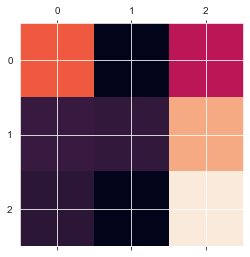

In [215]:
fig = plt.figure()
plt.matshow(cm)
plt.savefig('Output/confusion_matrix.png', dpi=1200)

In [237]:
import statsmodels.api as sm
from sklearn.metrics import (confusion_matrix, accuracy_score)
model = sm.MNLogit(y_train,sm.add_constant(X_train)).fit(method='bfgs', maxiter=2000) #.fit_regularized(method='l1', maxiter=2000, alpha=5.1)
# model = sm.MNLogit(y_train, sm.add_constant(X_train)).fit(maxiter=1000)
print(model.summary())
training_prediction = model.predict(sm.add_constant(X_train)).idxmax(axis=1)
# prediction = list(map(round, yhat))
# confusion matrix
cm = confusion_matrix(y_train, training_prediction)
print ("Confusion Matrix : \n", cm)

# accuracy score of the model
print('Training accuracy = ', accuracy_score(y_train, training_prediction))

# prediction = model.predict(sm.add_constant(test.df)).idxmax(axis=1)
predicted_values = pd.DataFrame(model.predict(sm.add_constant(test.df)).idxmax(axis=1), index=test.df.index, columns=[0])
predicted_y = decode_dep_var(predicted_values)
prediction_output = concat_id_and_predictions(test, predicted_y)
prediction_output.to_csv('pointon_predictions_Logistic.csv', index=False)
prediction_output # region:
#
# 'water_quality: fluoride abandoned', 'payment_type: per bucket', 'extraction_type_class: rope pump'

Optimization terminated successfully.
         Current function value: 0.666018
         Iterations: 500
         Function evaluations: 501
         Gradient evaluations: 501
                            MNLogit Regression Results                           
Dep. Variable:     status_group_encoding   No. Observations:                59087
Model:                           MNLogit   Df Residuals:                    58983
Method:                              MLE   Df Model:                          102
Date:                   Thu, 23 Mar 2023   Pseudo R-squ.:                  0.2512
Time:                           10:51:47   Log-Likelihood:                -39353.
converged:                          True   LL-Null:                       -52553.
Covariance Type:               nonrobust   LLR p-value:                     0.000
            status_group_encoding=1       coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------

ValueError: Classification metrics can't handle a mix of multiclass and continuous-multioutput targets

The final kfold confusion matrix: 
 [[0.56592765 0.19719953 0.23687281]
 [0.10968495 0.62077013 0.26954492]
 [0.13636364 0.29020979 0.57342657]]
The standard confusion matrix: 
 [[0.60730795 0.0046225  0.38806956]
 [0.15169195 0.01983664 0.82847141]
 [0.09177314 0.00358367 0.90464319]]
List of logit reg possible accuracies using under-sampling: ['0.59', '0.62', '0.59', '0.61', '0.59']
Mean accuracy: 60.03% vs the unrestricted model: 69.62%
List of MLP possible accuracies using under-sampling: ['0.65', '0.66', '0.66', '0.66', '0.63']
Mean accuracy: 65.11% vs the unrestricted model: 71.76%

The final kfold confusion matrix: 
 [[0.59894048 0.18214397 0.21891555]
 [0.12201964 0.63970703 0.23827334]
 [0.10628019 0.30839956 0.58532024]]
The standard confusion matrix: 
 [[0.60730795 0.0046225  0.38806956]
 [0.15169195 0.01983664 0.82847141]
 [0.09177314 0.00358367 0.90464319]]
List of logit reg possible accuracies using over-sampling: ['0.61', '0.61', '0.61', '0.62', '0.61']
Mean accuracy: 61

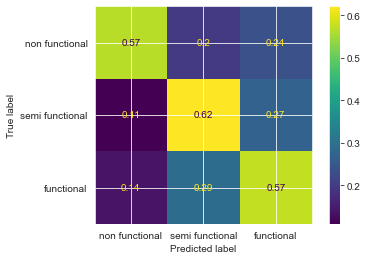

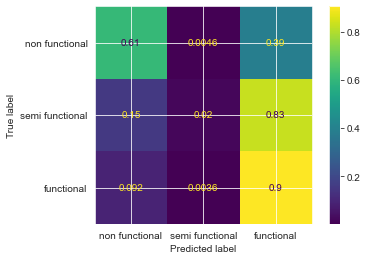

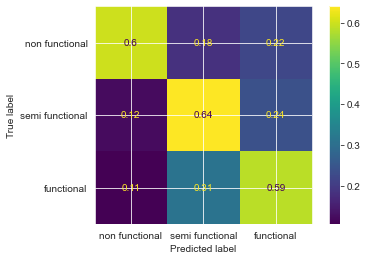

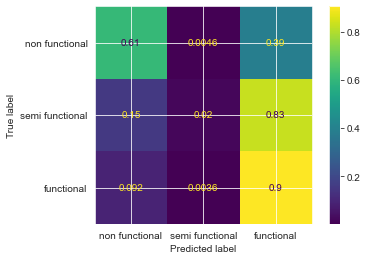

In [357]:
# Getting an overall test-train split
from sklearn.model_selection import train_test_split
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_train, y_train,
                                                    stratify=y_train,
                                                    test_size=0.2)
# Dealing with the imbalanced classes
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import ConfusionMatrixDisplay
from statistics import mean
from sklearn.metrics import f1_score
import inspect
for sampler in [RandomUnderSampler, RandomOverSampler]:
    sampler_type = inspect.getmembers(sampler, lambda a:not(inspect.isroutine(a)))[-1][-1]
    # Either under- or over- sample the data
    if sampler == RandomUnderSampler:
        rs = sampler(replacement=False, random_state=0)
    else:
        rs = RandomOverSampler(random_state=0)
    X_resampled, y_resampled = rs.fit_resample(X_train, y_train)

    # Kfold sampling but maintaining the equal class balance
    f1_scores = []
    mlp_f1_scores = []
    skf = StratifiedKFold(n_splits=5, shuffle=False)
    for train_index, test_index in skf.split(X_resampled, y_resampled):
        X_train_kfold, X_test_kfold = X_resampled.iloc[train_index], X_resampled.iloc[test_index]
        y_train_kfold, y_test_kfold = y_resampled.iloc[train_index], y_resampled.iloc[test_index]

        # Applying the logistic regression model
        lr_model = sm.MNLogit(y_train_kfold,sm.add_constant(X_train_kfold)).fit(method='bfgs', maxiter=2000, disp=0) #.fit_regularized(method='l1', maxiter=2000, alpha=5.1)
        lr_prediction = lr_model.predict(sm.add_constant(X_test_kfold)).idxmax(axis=1)
        f1_scores.append(f1_score(y_test_kfold, lr_prediction, average='weighted'))

        # Applying the MLP model
        mlp_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, alpha=0.5) # Don't want to be too simple but don't want to overfit - (93inputs + 3outputs)*2/3 as per https://medium.com/geekculture/introduction-to-neural-network-2f8b8221fbd3
        mlp_model.fit(X_train_kfold, y_train_kfold)
        mlp_prediction = mlp_model.predict(X_test_kfold)
        mlp_f1_scores.append(f1_score(y_test_kfold, mlp_prediction, average='weighted'))

    # print the final confusion matrix
    print('The final kfold confusion matrix: \n', confusion_matrix(y_test_kfold, lr_prediction, normalize='true'))
    cm = confusion_matrix(y_test_kfold, lr_prediction, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['non functional', 'semi functional', 'functional'])
    disp.ax_.get_images()[0].set_clim(0, 1) # set scale to be [0,1]
    disp.plot()
    plt.savefig(f'Output/confusion_matrix_kfold_{sampler_type}.png', dpi=1200)

    # Applying the models to the full dataset with no under/over sampling and a simple 80:20 train/test split:
    lr_model = sm.MNLogit(y_train_all,sm.add_constant(X_train_all)).fit(method='bfgs', maxiter=2000, disp=0) #.fit_regularized(method='l1', maxiter=2000, alpha=5.1)
    lr_prediction = lr_model.predict(sm.add_constant(X_test_all)).idxmax(axis=1)
    print('The standard confusion matrix: \n', confusion_matrix(y_test_all, lr_prediction, normalize='true'))
    cm = confusion_matrix(y_test_all, lr_prediction, normalize='true')
    disp.ax_.get_images()[0].set_clim(0, 1) # set scale to be [0,1]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['non functional', 'functional needs repair', 'functional'])
    disp.plot()
    plt.savefig(f'Output/confusion_matrix_standard_{sampler_type}.png', dpi=1200)

    mlp_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, alpha=0.5) # Don't want to be too simple but don't want to overfit - (93inputs + 3outputs)*2/3 as per https://medium.com/geekculture/introduction-to-neural-network-2f8b8221fbd3
    mlp_model.fit(X_train_all, y_train_all)
    mlp_prediction = mlp_model.predict(X_test_all)

    # Summarise and print the output:
    print(f'List of logit reg possible accuracies using {sampler_type}:', ["%.2f" % num for num in f1_scores])
    print(f'Mean accuracy: {round(mean(f1_scores)*100, 2)}% vs the unrestricted model: {round(f1_score(y_test_all, lr_prediction, average="weighted")*100, 2)}%')
    print(f'List of MLP possible accuracies using {sampler_type}:', ["%.2f" % num for num in mlp_f1_scores])
    print(f'Mean accuracy: {round(mean(mlp_f1_scores)*100, 2)}% vs the unrestricted model: {round(f1_score(y_test_all, mlp_prediction, average="weighted")*100, 2)}%\n')

In [240]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_train = label_binarizer.transform(y_train)

RocCurveDisplay.from_predictions(
    y_onehot_train[:, 0],
    training_prediction,
    name=f"One vs the rest",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves:\nVirginica vs (Setosa & Versicolor)")
plt.legend()
plt.show()

# fig, ax = plt.subplots(figsize=(6, 6))
# from itertools import cycle
# n_classes = 3
# colors = cycle(["aqua", "darkorange", "cornflowerblue"])
# for class_id, color in zip(range(3), colors):
#     RocCurveDisplay.from_predictions(
#         y_onehot_train[:, class_id],
#         training_prediction,
#         name=f"ROC curve for {class_id}",
#         color=color,
#         ax=ax,
#     )
#
# plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
# plt.axis("square")
# plt.xlabel("False Positive Rate")
# plt.ylabel("True Positive Rate")
# plt.title("Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass")
# plt.legend()
# plt.show()

ValueError: y should be a 1d array, got an array of shape (59087, 3) instead.

In [9]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(X_train, y_train)
predicted_y = model.predict(test.df)
predicted_y

array([2, 0, 2, ..., 2, 2, 0], dtype=int64)

In [11]:
def decode_dep_var(model_predictions):
    # Do we want to do these?
    model_predictions = pd.DataFrame(model_predictions)
    model_predictions['status_group'] = model_predictions[0].replace(0, "non functional")
    model_predictions['status_group'].replace(1, "functional needs repair", inplace=True)
    model_predictions['status_group'].replace(2, "functional", inplace=True)
    model_predictions.drop(columns=[0], inplace=True)
    return model_predictions

def concat_id_and_predictions(test_object, predictions):
    prediction_output = pd.DataFrame()
    prediction_output['id'] = test_object.ids
    prediction_output['status_group'] = predictions
    return prediction_output

In [12]:
predicted_y = decode_dep_var(predicted_y)
prediction_output = concat_id_and_predictions(test, predicted_y)
prediction_output.to_csv('pointon_predictions_RF.csv', index=False)
prediction_output

,id,status_group
0,50785,functional
1,51630,non functional
2,17168,functional
3,45559,non functional
4,49871,functional
...,...,...
14845,39307,non functional
14846,18990,functional
14847,28749,functional
14848,33492,functional


In [194]:
# Regression imputation
# for feature in ['amount_tsh', 'population', 'gps_height']: # any others??
#     training.regression_imputation(feature)

In [112]:
training_df_for_test_imputations['permit'].value_counts()

true       38703
false      17341
unknown     3043
Name: permit, dtype: int64

<Axes: xlabel='permit', ylabel='status_group'>

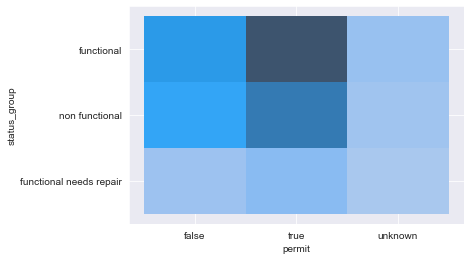

In [111]:
sns.histplot(data=training_df_for_test_imputations, x='permit', y='status_group')
# df['longitude_new'] = df['longitude'].fillna(df.groupby(['region', 'ward'])['longitude'].transform('mean'))

In [19]:
# sns.histplot(data=df.loc[df['extraction_type_class'].isin(['other - mkulima/shinyanga', 'climax', 'walimi', 'other - play pump', 'cemo'])], x='extraction_type_class', hue='status_group', stat='percent', multiple="dodge")

In [20]:
# sns.histplot(data=df.loc[(df['num_private']>0) & (df['num_private']<100)], x='num_private', hue='status_group', stat='percent', multiple="dodge")

In [21]:
# adapted from https://stackoverflow.com/questions/34615854/seaborn-countplot-with-normalized-y-axis-per-group
# (df.loc[df['num_private']<10]
# .groupby('num_private')['status_group']
# .value_counts(normalize=True)
# .mul(100)
# .rename('percent')
# .reset_index()
# .pipe((sns.catplot,'data'), x='num_private',y='percent',hue='status_group',kind='bar'))

In [23]:
# sns.histplot(data=df, x='region', y='status_group', cbar=True) # distribution/histogram of region vs status_group using the count in each bin - will need to redo the region codes and use these instead of the region column

In [24]:
# from sklearn.impute import KNNImputer
# imputer = KNNImputer(n_neighbors=19287)
# dummies = pd.get_dummies(df['subvillage']).add_prefix('subvillage'+": ").iloc[:,:-1]
# df = pd.concat([df, dummies], axis=1) # leave last dummy to avoid DV trap
# vars = list(dummies) + ['longitude', 'latitude', 'gps_height']
# imputer.fit_transform(df[vars])

In [27]:
# sns.boxplot(data=df.loc[(df['amount_tsh']>0) & (df['amount_tsh']<500)], x='amount_tsh')
# df.loc[(df['amount_tsh']>0) & (df['amount_tsh']<500)]

In [28]:
# df.loc[(df['amount_tsh']>0) & (df['amount_tsh']<400), 'amount_tsh'].quantile(np.linspace(.1, 1, 18, 0))

In [29]:
# Outliers
# sns.boxplot(data=df.loc[df['amount_tsh']>10000], x='status_group', y='amount_tsh')
# sns.violinplot(data=df, x='status_group', y='amount_tsh') # so there is a correlation between broken/amount_tsh

<Axes: xlabel='status_group', ylabel='population'>

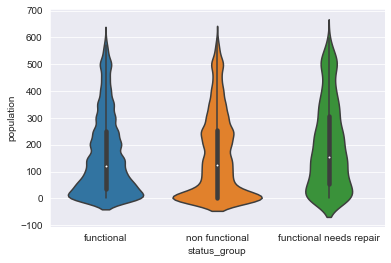

In [200]:
sns.violinplot(data=training.df.loc[training.df['population']<600], x='status_group', y='population')
# df.loc[df['population']<600, 'population'].describe()
# df.loc[df['status_group']=='non functional']

<Axes: xlabel='amount_tsh', ylabel='waterpoint_type_group'>

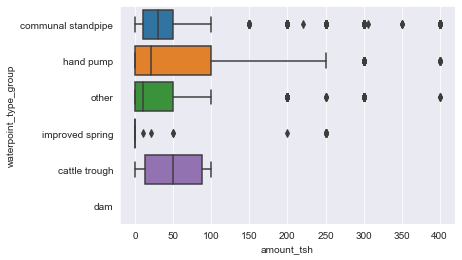

In [31]:
sns.boxplot(data=training.df, x='amount_tsh', y='waterpoint_type_group')

region       ward           
tabora       sungwisi             1
kigoma       machinjioni          1
mara         nyamtinga            1
morogoro     uwanja wa ndege      1
mtwara       majengo              1
                               ... 
arusha       nduruma            205
iringa       mdandu             231
kilimanjaro  siha kati          232
iringa       imalinyi           252
             igosi              307
Name: NaNs, Length: 2173, dtype: int64

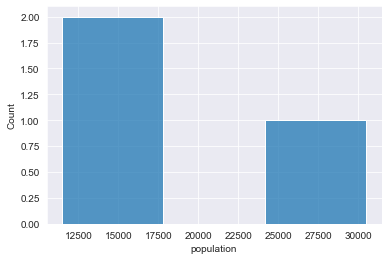

In [32]:
# sns.histplot(data=df, x='age')
sns.histplot(data=training.df.loc[training.df['population']>10000], x='population')
# plt.savefig('Output/dep_var.png', dpi=1200)
training.df.loc[training.df['population']>10000, ['population', 'longitude', 'latitude', 'region', 'subvillage', 'ward']]
# df['population'].quantile(np.linspace(.1, 1, 99, 0))
subdf = training.df.loc[training.df['ward']=='masuguru', ['longitude', 'latitude', 'region', 'ward', 'subvillage', 'population']].sort_values(by=['region', 'ward', 'subvillage']) # impute with the region and ward average!!
# df.columns
# sum(subdf.loc[subdf['population']<25000,'population'])/len(subdf.loc[subdf['population']<25000,'population'])
# subdf
training.df.groupby(['region','ward']).count().sort_values('NaNs')['NaNs']

In [33]:
# sns.kdeplot(data=df.loc[df['amount_tsh']<10000], x='amount_tsh', fill=True)

In [127]:
# sns.histplot(data=df.loc[df['amount_tsh']>0], x='amount_tsh', bins=10)
sns.pairplot(data=training.df, hue='status_group')


KeyboardInterrupt



Error in callback <function flush_figures at 0x000001E79110AEE0> (for post_execute):



KeyboardInterrupt



In [35]:
# Correlation between the variables
training.df.corr()

,amount_tsh,gps_height,longitude,latitude,population,age,status_group_encoding,NaNs
amount_tsh,1.000000,0.068761,-0.168865,-0.154301,0.003255,0.057333,0.052160,-0.276369
gps_height,0.068761,1.000000,-0.569910,0.281220,-0.039622,0.021225,0.152932,0.222164
longitude,-0.168865,-0.569910,1.000000,-0.308643,-0.097411,-0.035284,-0.005425,-0.482353
latitude,-0.154301,0.281220,-0.308643,1.000000,0.047701,-0.016951,0.015397,0.212746
population,0.003255,-0.039622,-0.097411,0.047701,1.000000,-0.028382,0.016776,-0.018691
age,0.057333,0.021225,-0.035284,-0.016951,-0.028382,1.000000,-0.291744,0.118777
status_group_encoding,0.052160,0.152932,-0.005425,0.015397,0.016776,-0.291744,1.000000,-0.051532
NaNs,-0.276369,0.222164,-0.482353,0.212746,-0.018691,0.118777,-0.051532,1.000000


<Axes: >

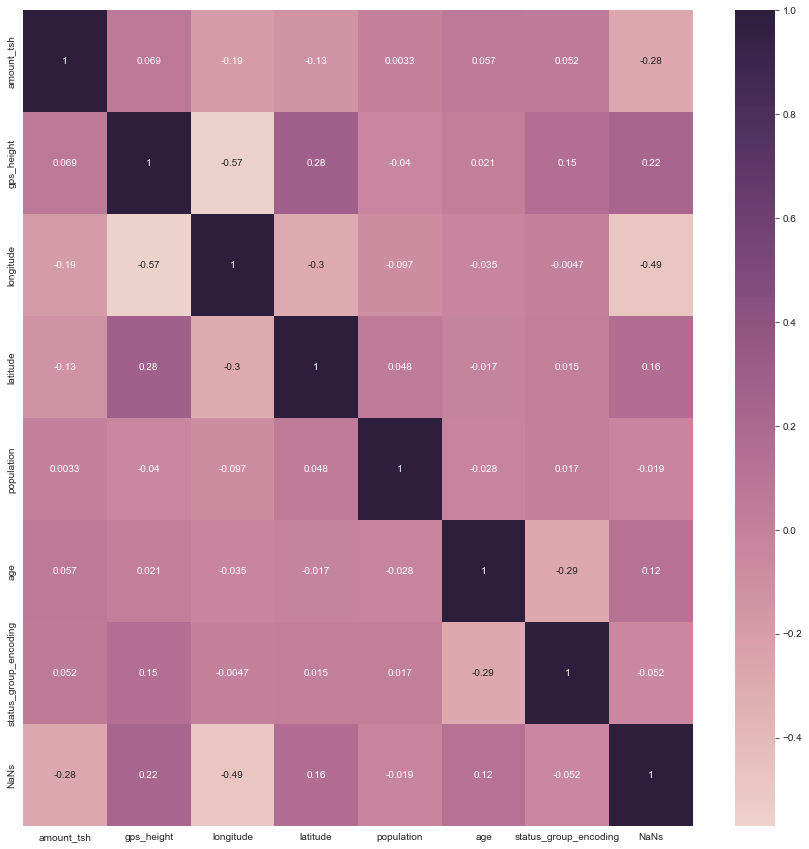

In [206]:
# Let's turn this correlation into a heatmap
plt.figure(figsize=(10,10))
sns.heatmap(training.df.corr(), cmap=sns.cubehelix_palette(as_cmap=True), annot=True) # , mask = (np.abs(df.corr() ) >= 0.5)

In [37]:
# sns.set(style="ticks", color_codes=True)
# sns.pairplot(df.select_dtypes(include=np.number))

JB's work

C:\Users\point\anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


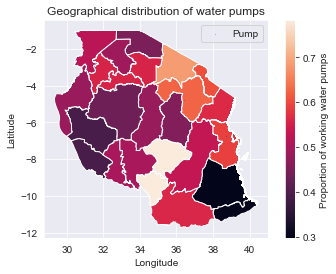

In [204]:
training.get_geo_graphic()

In [217]:
# JP's analysis
pointon = copy.deepcopy(training)
# define the multinomial logistic regression model
model = linear_model.LogisticRegression(multi_class='multinomial', solver='lbfgs')
pointon_x = pointon.df.loc[:,pointon.df.columns != 'status_group_encoding']
pointon_y = pointon.df['status_group_encoding']
model.fit(X = pointon_x, y = pointon_y)

predicted_values = pd.DataFrame(model.predict(pointon_x), index=pointon_x.index, columns=['prediction'])
pointon.df = pointon.df.join(predicted_values)
pointon.df['Accurate prediction'] = np.where(pointon.df['status_group_encoding']==pointon.df['prediction'], 1, 0)

# summarize the predicted class
print('Prediction Accuracy: %d' % pointon['Accurate prediction'].mean())

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [47]:
# probit model
# import statsmodels.api as smf
# probit_model=smf.Probit(y,X)
# result=probit_model.fit()
# print(result.summary2())

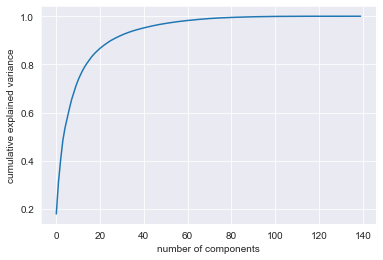

In [218]:
pca = PCA().fit(pointon.df.dropna())
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [225]:
pca = PCA(0.95).fit(pointon.df.dropna())
pca.n_components_

41

In [146]:
# exclude cols with too many (or only 1) categories
pca = PCA(n_components=2)
pca.fit(pointon_x.dropna())
print(pca.explained_variance_)
X_pca = pca.transform(pointon_x.dropna())
X_pca

[2.45232608 1.55117358]


array([[-0.22099343, -1.07549907],
       [ 0.22836442,  2.04594757],
       [ 1.74592172, -0.53561159],
       ...,
       [ 0.64079041, -2.11352072],
       [-1.95363224,  0.25185421],
       [ 0.65782794, -2.03414563]])

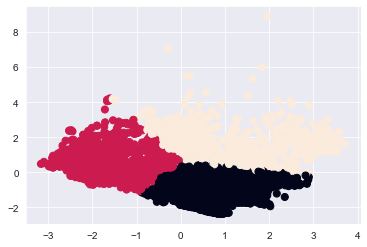

In [149]:
from sklearn.cluster import KMeans
Kmean = KMeans(n_clusters=3)
Kmean.fit(X_pca)
plt.scatter(X_pca[ : , 0], X_pca[ : , 1], s =50, c=Kmean.labels_.astype(float))
# plt.scatter(-0.94665068, -0.97138368, s=200, c='g', marker=’s’)
# plt.scatter(2.01559419, 2.02597093, s=200, c=’r’, marker=’s’)
plt.show()

In [237]:
# from sklearn.cross_decomposition import PLSRegression
# pls = PLSRegression(n_components=1) # multi_class='multinomial', solver='lbfgs'

In [235]:
training.df.describe()

,amount_tsh,gps_height,longitude,latitude,population,age,status_group_encoding,NaNs
count,12885.000000,38916.000000,59149.000000,59149.000000,37973.000000,38648.000000,59149.000000,59149.000000
mean,66.543489,1021.246659,35.106556,-5.802805,281.218234,15.354067,1.158921,1.889482
std,88.665822,609.806565,2.586687,2.816635,564.993112,12.487614,0.949796,1.647714
min,0.000000,1.000000,29.607122,-11.649440,1.000000,0.000000,0.000000,0.000000
25%,5.000000,394.000000,33.280764,-8.555373,40.000000,5.000000,0.000000,1.000000
50%,30.000000,1167.500000,34.926411,-5.043410,150.000000,13.000000,2.000000,1.000000
75%,100.000000,1499.000000,37.180494,-3.333518,324.000000,25.000000,2.000000,4.000000
max,400.000000,2770.000000,40.345193,-0.998464,30500.000000,53.000000,2.000000,6.000000


In [266]:
# import rioxarray  as rxr
#
# dataarray = rxr.open_rasterio('af_dem_3_3.tif')
#
# df = dataarray[0].to_pandas()

RasterioIOError: af_dem_3_3.tif: No such file or directory